In [1]:
import os
import sys
import cv2
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch 
from pykeops.torch import LazyTensor
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import pickle

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [2]:
split = "split_20231212"
experiment = "FWF003"
cell_type = "Distal"
N = 512

In [3]:
def sample_grid(n, dim=2,dtype=torch.float32,device="cpu"):
    grid_points = torch.linspace(0,1,n,dtype=dtype,device=device)
    grid_points = torch.stack(
        torch.meshgrid((grid_points,) * dim, indexing="ij"), dim=-1
    )
    grid_points = grid_points.reshape(-1, dim)
    return grid_points

y_grid = sample_grid(N)
R = 0.075

def neighbours_grid(i,y_grid,R):
    yi = y_grid[i,:].reshape((1,2))
    return (((yi - y_grid)**2).sum(1) <= R**2).float().squeeze()

def neighbours_grid_point(y,y_grid,R):
    yi = y.reshape((1,2))
    return (((yi - y_grid)**2).sum(1) <= R**2).float().squeeze()

In [4]:
neighbours_grid(1000,y_grid,R).sum()

tensor(2089.)

In [5]:
data_dir = split+"_"+experiment+"_smooth/"+cell_type+"/data/"

In [6]:
def open_data(data_dir,N=512):
    T = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])
    data = torch.zeros((N,N,T))
    for t in range(1,T+1):
        with open(data_dir + "data_" + str(t) + ".pkl", 'rb') as file:
            data[:,:,t-1] = pickle.load(file)
    return data

data = open_data(data_dir,N=N)

In [7]:
# plt.plot(smooth_max)
# # plt.plot(data.reshape((N*N,T))[data_max[1][-1].item(),:])

In [8]:
from matplotlib.widgets import Button, Slider
from matplotlib import colors

def smooth_max(data,y_grid,R):
    N = data.shape[0]
    T = data.shape[2]
    data_max = torch.max(data.reshape((N*N,T)),dim=0)
    ngh_max = neighbours_grid(data_max[1][-1].item(),y_grid,R).bool()
    smooth_max = data.reshape((N*N,T))[ngh_max,:].sum(0) * (1/N)**2
    return data_max[1][-1].item(), smooth_max

def smooth_peak(data,point,y_grid,R):
    N = data.shape[0]
    T = data.shape[2]
    ngh_peak = neighbours_grid_point(point,y_grid,R).bool()
    smooth_peak = data.reshape((N*N,T))[ngh_peak,:].sum(0) * (1/N)**2
    return smooth_peak

def cmap(cell_type):
    if cell_type=="Proximal":
        # cmap_base = pl.cm.Purples
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["m","m"], N=1000)
    elif cell_type=="Distal":
        # cmap_base = pl.cm.Greens
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["g","g"], N=1000)
    else:
        cmap_base = pl.cm.Blues
    # Get the colormap colors
    cmap = cmap_base(np.arange(cmap_base.N))
    # Set alpha
    cmap[:,-1] = np.linspace(0, 1, cmap_base.N)**2
    # Create new colormap
    cmap = ListedColormap(cmap)
    return cmap
    
def data_to_smax(data,y_grid,R=0.1,T0=1,cell_type=cell_type,peak=None):
    if peak is None:
        index, smax = smooth_max(data,y_grid,R)
        yx = y_grid[index,0].item()
        yy = y_grid[index,1].item()
    else:
        smax = smooth_peak(data,peak,y_grid,R)
        yx = peak[0].item()
        yy = peak[1].item()
    fig, axs = plt.subplots(1,2,figsize=(9,4))
    im = axs[0].imshow(data[:,:,T0-1].numpy().transpose(),origin='lower',cmap=cmap(cell_type),vmin=0.0,vmax=data[:,:,-1].max().item())
    axs[0].invert_yaxis()
    axs[0].set_aspect("equal")
    axs[0].set_title("Density")
    
    scat = axs[0].scatter([yx*N],[yy*N],s=15,c='red')
    circ = axs[0].plot(N*(yx + R*np.cos(2*math.pi*np.linspace(0,1,100))),N*(yy + R*np.sin(2*math.pi*np.linspace(0,1,100))),c='r')

    maxplot, = axs[1].plot(smax)
    timeline = axs[1].vlines(x=T0,ymin=0,ymax=1.1*smax.max().item(),color='r')
    axs[1].set_title("Peak size")

    # axs[1].set_xlim(0,T)
    # axs[1].set_ylim(0,1.05*smax.max())
    fig.subplots_adjust(left=0.25, bottom=0.25)
    
    
    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axtime,
        label='FRAME',
        valmin=1,
        valmax=data.shape[2],
        valinit=T0,
        valstep=1
    )
    
    def update(val):
        im.set_data(data[:,:,frame_slider.val-1].numpy().transpose())
        # maxplot.set_ydata(smax[:frame_slider.val-1])
        timeline.set_segments([np.array([[frame_slider.val-1, 0], [frame_slider.val-1, 1.1*smax.max().item()]])])
        fig.canvas.draw_idle()
    
    frame_slider.on_changed(update)
    
    
    return fig, axs



In [9]:
def make_video(number_of_frames=None,prefix="t_",simu_name="simu",video_name='funny_video',frame_dir="frames",rate=40):
    img_array = []
    current_directory = os.getcwd()
    frame_directory = current_directory+"/"+simu_name+"/"+frame_dir
    if number_of_frames is None:
        number_of_frames = len([name for name in os.listdir(frame_directory) if os.path.isfile(os.path.join(frame_directory, name))])
    for count in range(number_of_frames):
        filename = frame_directory+"/"+prefix+str(count)+'.png'
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    out = cv2.VideoWriter(simu_name+"/"+video_name+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), rate,size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

(<Figure size 900x400 with 3 Axes>,
 array([<Axes: title={'center': 'Density'}>,
        <Axes: title={'center': 'Peak size'}>], dtype=object))

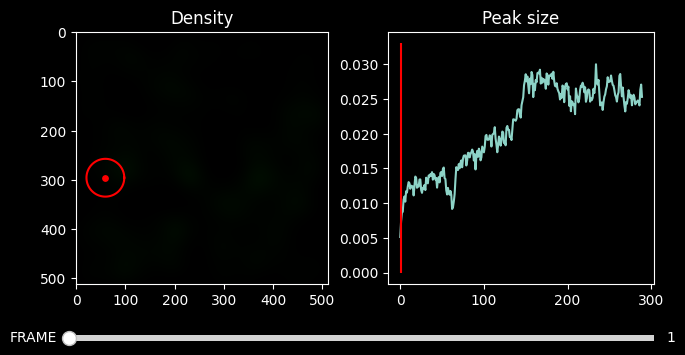

In [10]:
%matplotlib widget
plt.style.use('dark_background')
data_to_smax(data,y_grid,R=0.075,T0=1)

In [11]:
# %matplotlib inline
# plt.style.use('dark_background')
# simu_name = split + "_" + experiment + "_smooth/" + cell_type
# frame_dir = simu_name + "/frames_maxpeak"
# os.mkdir(frame_dir)

# for t in range(data.shape[2]):
#     fig, axs = data_to_smax(data,y_grid,R=0.075,T0=t)
#     fig.savefig(frame_dir + f"/t_{t}.png" )
#     plt.close()
    
# make_video(simu_name=simu_name,video_name="max_peak",frame_dir="/frames_maxpeak")


In [12]:
# for k in range(9):
#     split = "split_20231212"
#     experiment = "FWF00"+str(k+1)
#     cell_type = "Proximal"
#     N = 512
#     data_dir = split+"_"+experiment+"_smooth/"+cell_type+"/data/"
#     data = open_data(data_dir,N=N)
#     fig, axs = data_to_smax(data,y_grid,R=0.1,cmapcolor="magenta",T0=data.shape[2])
#     fig.suptitle(experiment + " (" + cell_type + ")")

In [13]:
# for k in range(9):
#     split = "split_20231212"
#     experiment = "FWF00"+str(k+1)
#     cell_type = "Distal"
#     N = 512
#     data_dir = split+"_"+experiment+"_smooth/"+cell_type+"/data/"
#     data = open_data(data_dir,N=N)
#     fig, axs = data_to_smax(data,y_grid,R=0.1,cmapcolor="green",T0=data.shape[2])
#     fig.suptitle(experiment + " (" + cell_type + ")")

In [14]:
def plot_all(split,experiment,cell_type,N=512,R=0.1):
    fig = plt.figure(figsize=(28,14))
    subfigs = fig.subfigures(3, 3, wspace=0.07)
    for k in range(9):
        sfi = int(k/3)
        sfj = k%3
        experiment_number = experiment+str(k+1)
        data_dir = split+"_"+experiment_number+"_smooth/"+cell_type+"/data/"
        try:
            data = open_data(data_dir,N=N)
            index, smax = smooth_max(data,y_grid,R)
            yx = y_grid[index,0].item()
            yy = y_grid[index,1].item()
            axs = subfigs[sfi,sfj].subplots(1,2)
            im = axs[0].imshow(data[:,:,-1].numpy().transpose(),origin='lower',cmap=cmap(cell_type),vmin=0.0,vmax=data[:,:,-1].max().item())
            axs[0].invert_yaxis()
            axs[0].set_aspect("equal")
            scat = axs[0].scatter([yx*N],[yy*N],s=15,c='red')
            circ = axs[0].plot(N*(yx + R*np.cos(2*math.pi*np.linspace(0,1,100))),N*(yy + R*np.sin(2*math.pi*np.linspace(0,1,100))),c='r')
            maxplot, = axs[1].plot(smax)
            subfigs[sfi,sfj].suptitle(experiment_number + " (" + cell_type + ")")
        except:
            print("There is a problem with " + experiment_number)
    return fig

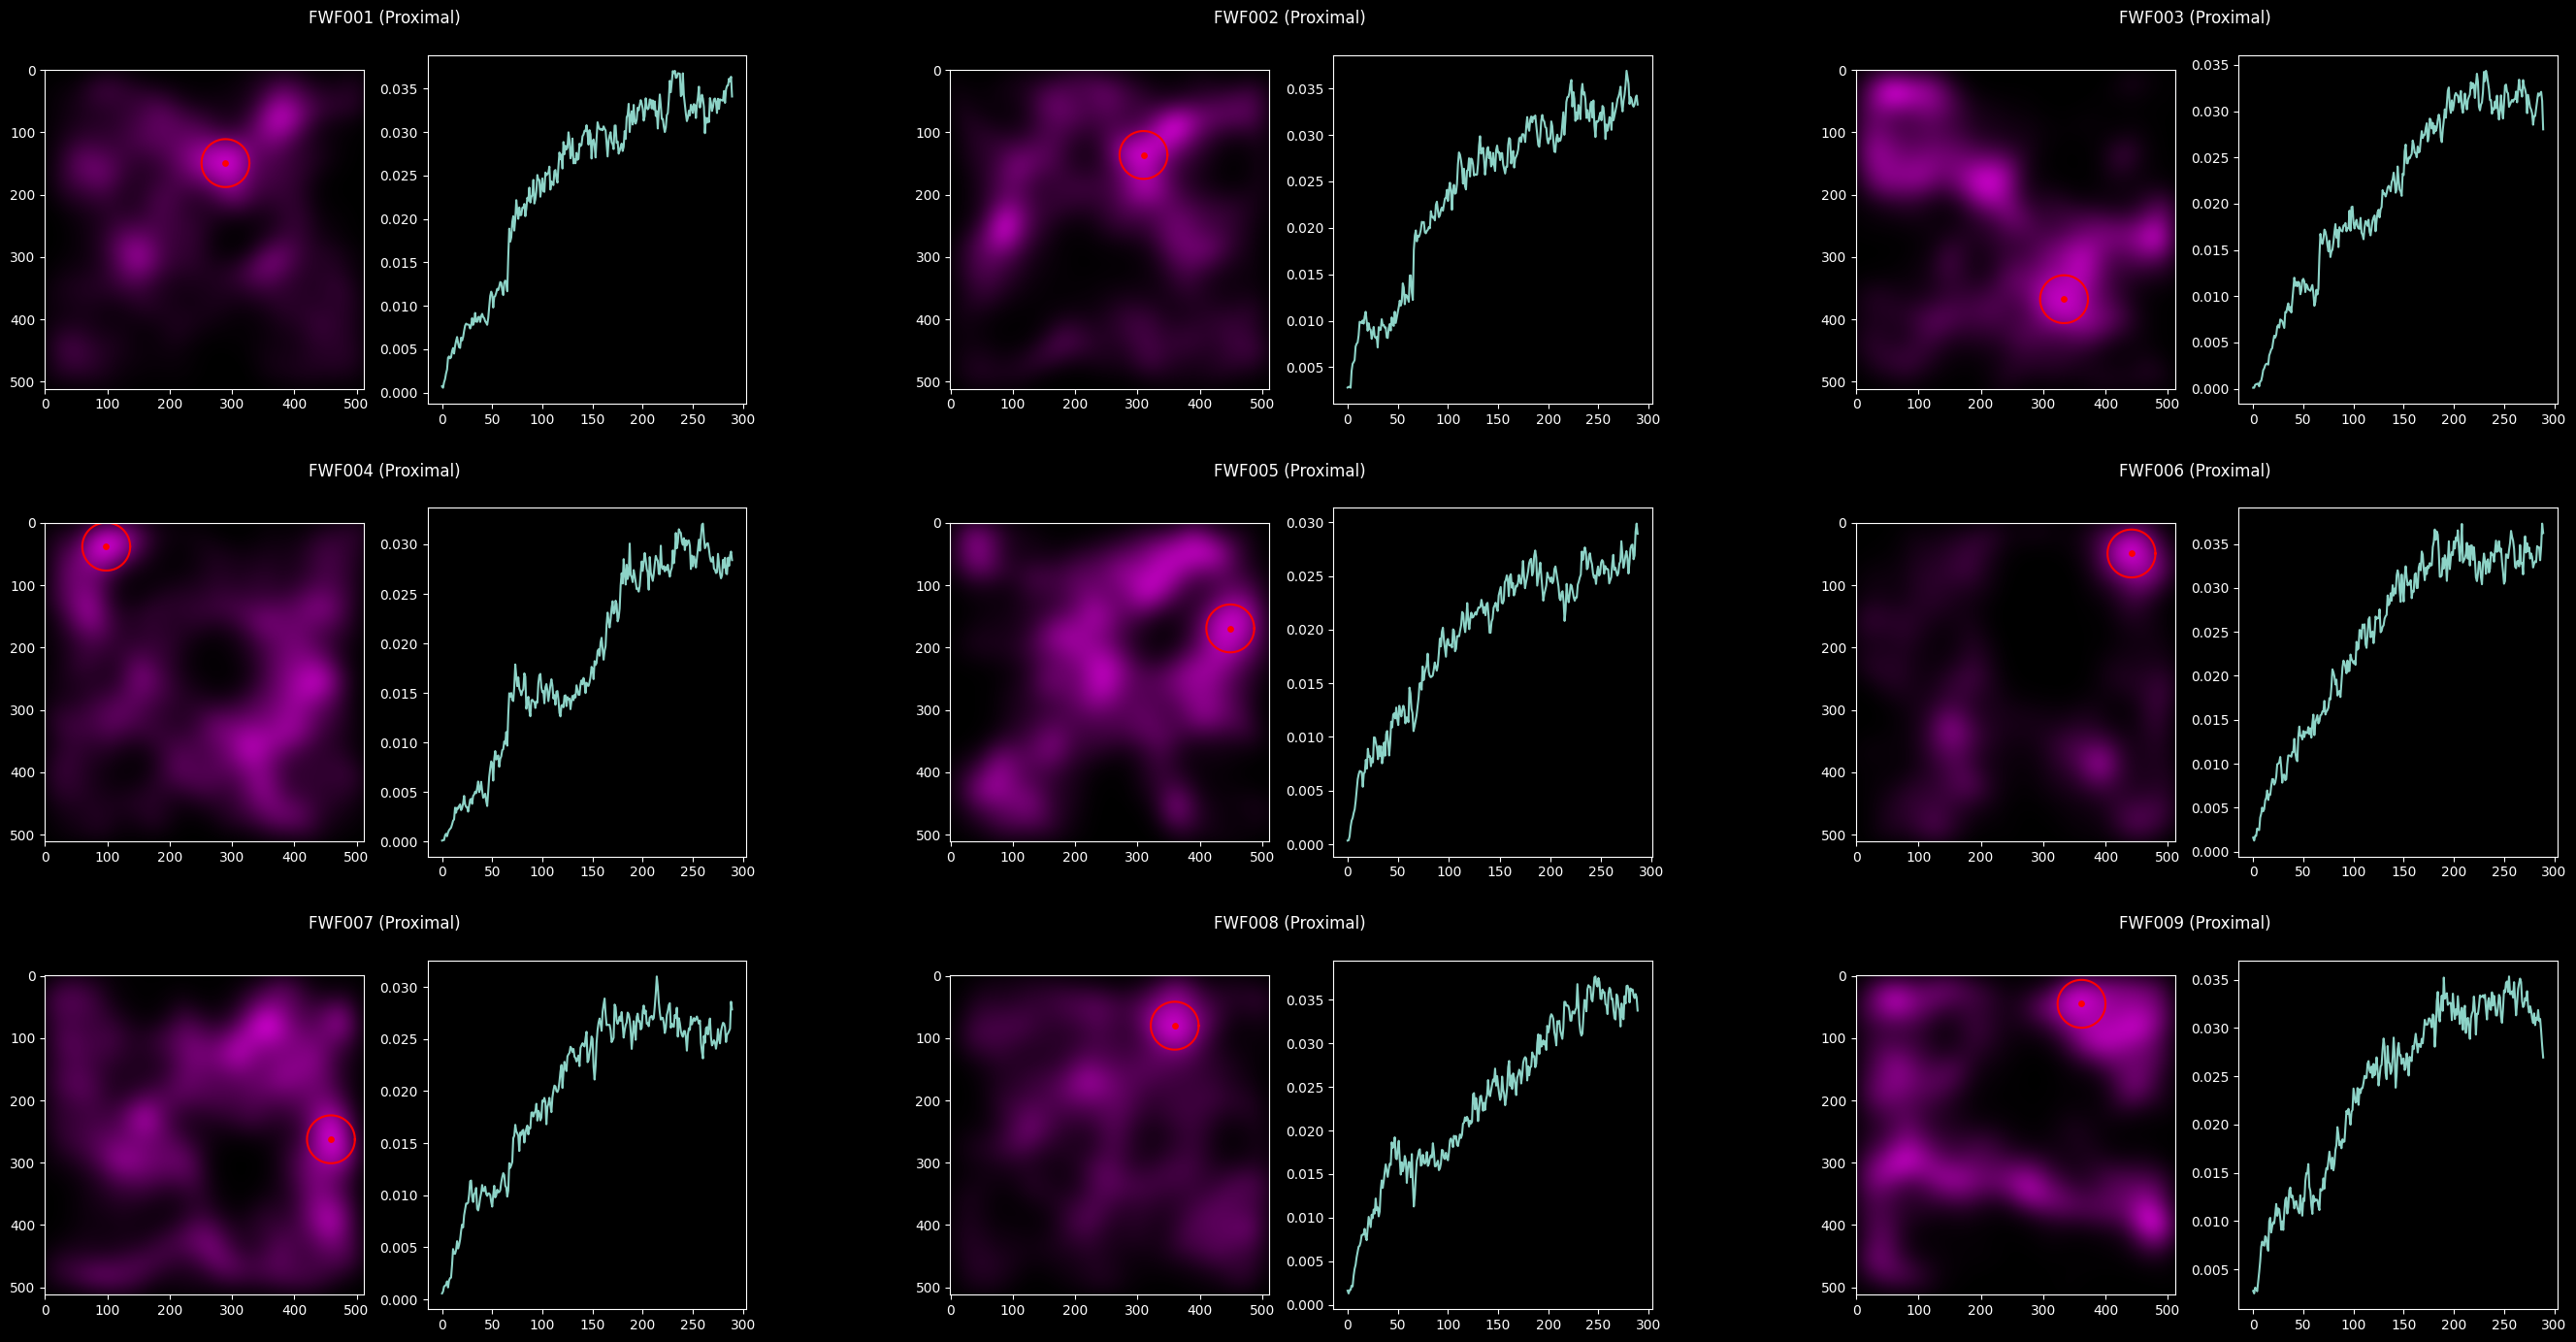

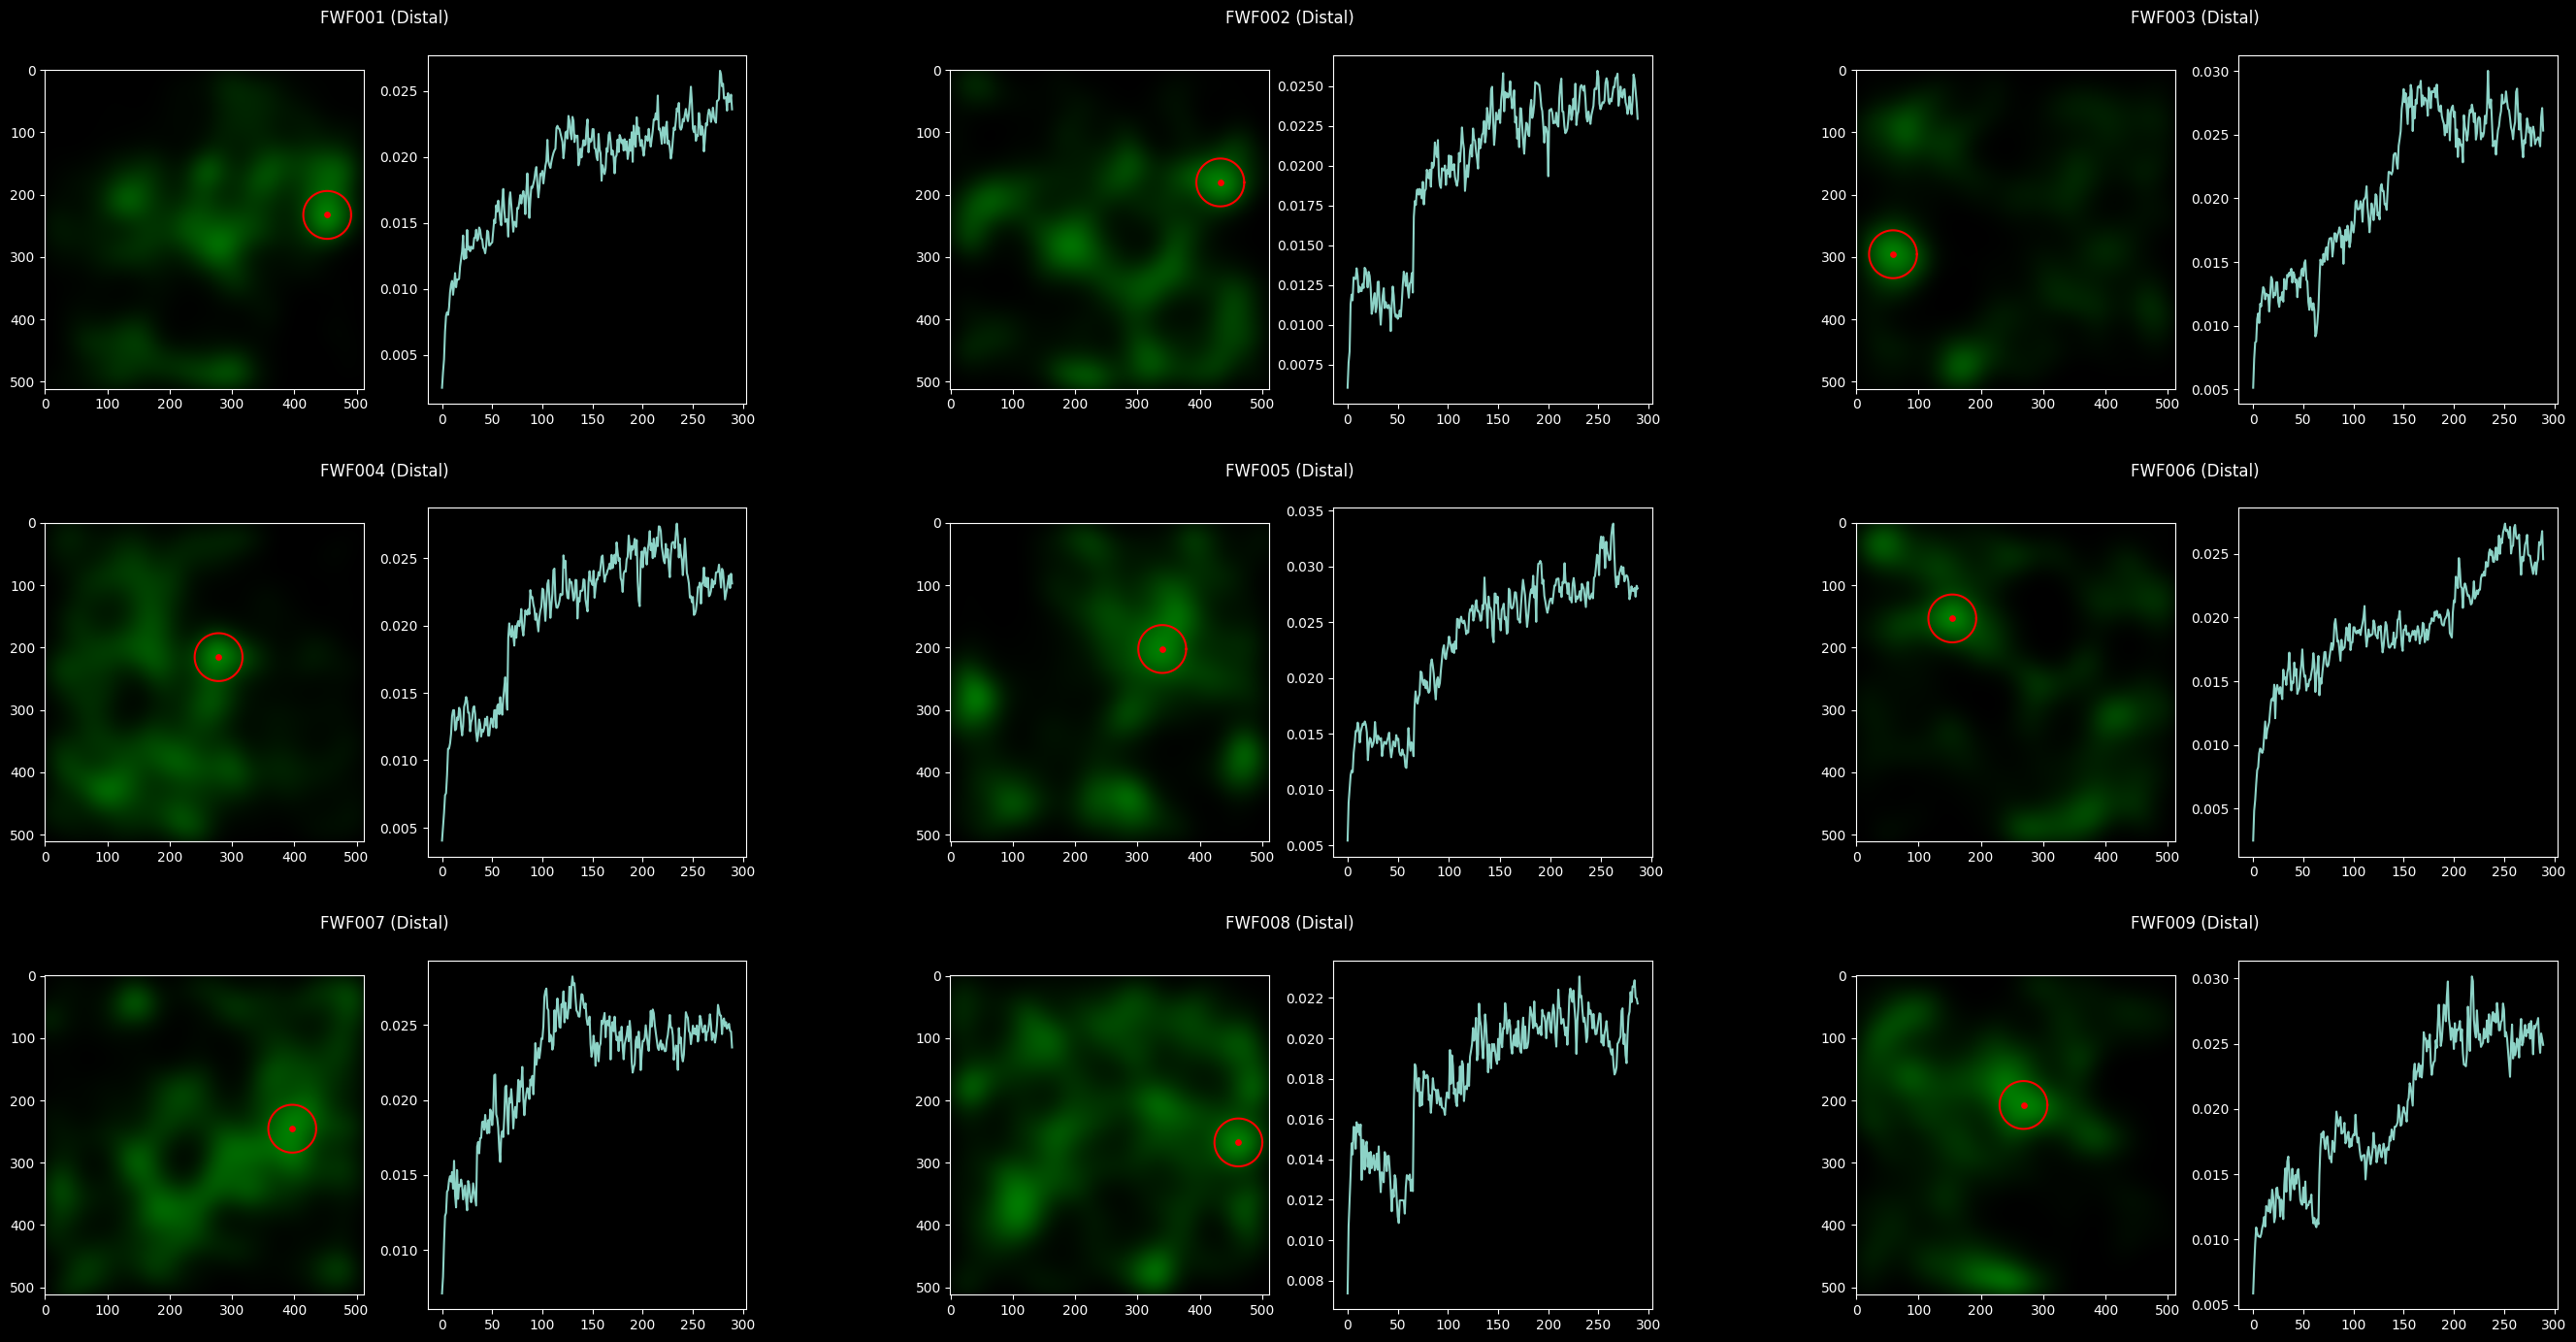

In [15]:
%matplotlib inline
plt.style.use('dark_background')

fig_prox = plot_all(split,"FWF00","Proximal",R=R)
fig_dist = plot_all(split,"FWF00","Distal",R=R)

fig_prox.savefig(split + "_FWF_Proximal_MaxPeak_dark.png")
fig_dist.savefig(split + "_FWF_Distal_MaxPeak_dark.png")

In [16]:
# %matplotlib inline
# fig_prox = plot_all(split,"NCF00","Proximal",R=R)
# fig_dist = plot_all(split,"NCF00","Distal",R=R)

# fig_prox.savefig(split + "_NCF_Proximal_MaxPeak.png")
# fig_dist.savefig(split + "_NCF_Distal_MaxPeak.png")

In [17]:
# %matplotlib inline
# fig_prox = plot_all(split,"RAF00","Proximal",R=R)
# fig_dist = plot_all(split,"RAF00","Distal",R=R)

# fig_prox.savefig(split + "_RAF_Proximal_MaxPeak.png")
# fig_dist.savefig(split + "_RAF_Distal_MaxPeak.png")